In [56]:
# 1. Setup
# ==============================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from graphviz import Digraph

In [57]:
# Make directories
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/interim", exist_ok=True)
os.makedirs("configs", exist_ok=True)


In [59]:
# 2. Load raw dataset
# ==============================
# If using uploaded file in Colab:
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv("diabetic_data.csv")

# If already available in your workspace:
df = pd.read_csv("/content/diabetic_data.csv")

# Save raw copy
df.to_csv("data/raw/diabetic_data.csv", index=False)

print(f"Raw dataset shape: {df.shape}")
print("Columns:", df.columns.tolist()[:10], "...")

Raw dataset shape: (33243, 50)
Columns: ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital'] ...



Outcome distribution (readmitted):
readmitted
NO     18608
>30    10846
<30     3788
NaN        1
Name: count, dtype: int64


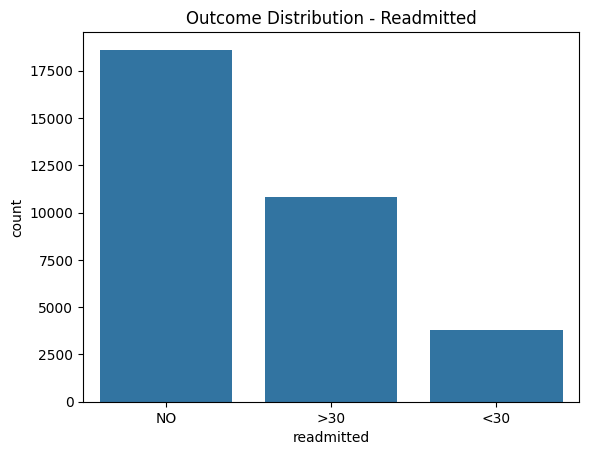

In [60]:
# 3. Inspect outcome variable
# ==============================
print("\nOutcome distribution (readmitted):")
print(df["readmitted"].value_counts(dropna=False))

sns.countplot(x="readmitted", data=df)
plt.title("Outcome Distribution - Readmitted")
plt.show()

In [61]:
# 4. Define cohort rules
# ==============================
initial_n = df.shape[0]

# Age filter: parse age range like [70-80)
df = df[df["age"].notna()]
df["age_min"] = df["age"].str.extract(r"\[(\d+)-").astype(int)
df = df[df["age_min"] >= 18]
after_age_n = df.shape[0]

# Drop missing outcome
df = df[df["readmitted"].notna()]
after_outcome_n = df.shape[0]

In [62]:
# 5. Encode outcome variable
# ==============================
# readmitted column has values: '<30', '>30', 'NO'
# Encode binary: 1 = readmitted (<30 or >30), 0 = NO
df["y"] = df["readmitted"].apply(lambda x: 0 if x == "NO" else 1)

print("\nEncoded outcome distribution:")
print(df["y"].value_counts())



Encoded outcome distribution:
y
0    18246
1    14467
Name: count, dtype: int64


In [65]:
# 6. Write cohort config
# ==============================
cohort_config = {
    "inclusion": ["Age >= 18 years"],
    "exclusion": ["Missing outcome"],
    "outcome": {
        "variable": "readmitted",
        "encoding": {"NO": 0, "<30": 1, ">30": 1}
    }
}

with open("configs/cohort.yml", "w") as f:
    yaml.dump(cohort_config, f, default_flow_style=False)

print("\nCohort config saved to configs/cohort.yml")



Cohort config saved to configs/cohort.yml


Cohort flow diagram saved as cohort_flow.png


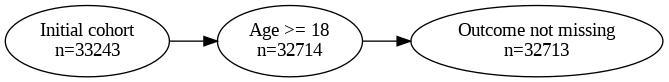

In [66]:
# 7. Cohort flow diagram
# ==============================
flow = Digraph(format="png")
flow.attr(rankdir="LR")

flow.node("N0", f"Initial cohort\nn={initial_n}")
flow.node("N1", f"Age >= 18\nn={after_age_n}")
flow.node("N2", f"Outcome not missing\nn={after_outcome_n}")

flow.edges([("N0", "N1"), ("N1", "N2")])

flow.render("cohort_flow", cleanup=True)
print("Cohort flow diagram saved as cohort_flow.png")

# Display in Colab
from IPython.display import Image
Image("cohort_flow.png")

In [68]:
# 8. Save cleaned dataset
# ==============================
df.to_csv("data/interim/cohort.csv", index=False)
print("\nCleaned cohort saved to data/interim/cohort.csv")


Cleaned cohort saved to data/interim/cohort.csv


In [70]:
import os
print(os.path.exists("data/interim/cohort.csv"))


True
